# Sampling Method Comparison

1. MH, non-MH Random Walk, Random Search, Coordinate Descent for two Attacks and two Detectors
    * Transform, ColorV1
    * OE, NAE
2. Show there is multiple local optima
    * OE, Transform and ColorV1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import torch
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from tqdm.notebook import tqdm
from ipywidgets import Output
sys.path.append('../../')

from models import load_pretrained
from augmentations import get_composed_augmentations
from attacks import Detector
from attacks.advdist import AdversarialDistributionTransform
from attacks.transforms import apply_colortransform_batch, apply_affine_batch
from attacks.mcmc import coordinate_descent
from loader import get_dataloader
from utils import batch_run, roc_btw_arr

In [2]:
device = 'cuda:0'

In [3]:
'''outlier exposure'''
attacked, cfg = load_pretrained('cifar_ood_oe_scratch/allconv', 'oe_scratch_allconv.yml', 'cifar10_allconv_oe_scratch_epoch_99.pt', 
                                root='../../pretrained', device=device,
                                network='allconv', num_classes=10)
d_aug = {'normalize':
           {'mean': (0.4914, 0.4822, 0.4465), 
            'std': (0.2471, 0.2435, 0.2615)}}
aug = get_composed_augmentations(d_aug)
detector = Detector(attacked, bound=-1, transform=aug, no_grad=True, use_rank=False)
detector.to(device);

Using normalize aug with params {'mean': (0.4914, 0.4822, 0.4465), 'std': (0.2471, 0.2435, 0.2615)}


In [2]:
'''NAE'''
attacked, cfg = load_pretrained('cifar_ood_nae/z32gn', 'z32gn', 'nae_8.pkl', 
                                root='../../pretrained', device=device)
detector = Detector(attacked, bound=-1, transform=None, no_grad=True, use_rank=False)
detector.to(device);

NameError: name 'load_pretrained' is not defined

In [4]:
'''load data'''
in_val_dl = get_dataloader({'batch_size': 64, 'dataset': 'CIFAR10_OOD', 'n_workers': 0, 'path': '../../datasets', 
                 'shuffle': False, 'split': 'validation'})
svhn_dl = get_dataloader({'batch_size': 64, 'dataset': 'SVHN_OOD', 'n_workers': 0, 'path': '../../datasets', 
                         'shuffle': False, 'split': 'evaluation'})
celeba_dl = get_dataloader({'batch_size': 512, 'dataset': 'CelebA_OOD', 'n_workers': 0, 'path': '../../datasets', 'size':32,
                         'shuffle': False, 'split': 'evaluation'})

Using No Augmentations
Using No Augmentations
Files already downloaded and verified
Files already downloaded and verified
Using No Augmentations
Using No Augmentations
Using downloaded and verified file: ../../datasets/test_32x32.mat
Using No Augmentations
Using No Augmentations


In [5]:
l_score = detector.learn_normalization(dataloader=in_val_dl, device=device, use_grad=False).cpu()

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [6]:
batch, _ = next(iter(svhn_dl))

In [7]:
from attacks.mcmc import sample_mh
import functools

In [9]:
affine = AdversarialDistributionTransform(detector=detector, transform='affineV0')
color = AdversarialDistributionTransform(detector=detector, transform='colorV1')
f = functools.partial(affine.energy, img=batch.to(device))
# f = functools.partial(color.energy, img=batch.to(device))
D = 5

In [55]:

d_sample = sample_mh(x0=torch.rand(64,D).to(device), energy_fn=f, n_step=1000, stepsize=0.2, T=2, bound=(0, 1), block=None, mh=True)
l_E = d_sample['l_E']
mean_E = l_E.mean(dim=1)
std_E = l_E.std(dim=1)
argmin = l_E.argmin(dim=0)
min_x = d_sample['l_x'][argmin, range(len(argmin)), :]
min_E = l_E[argmin, range(len(argmin))]
cummin = torch.cummin(d_sample['l_E'], dim=0).values.mean(dim=1)

100%|██████████| 1000/1000 [00:56<00:00, 17.68it/s]


## 1. 

## 2. Existence of Local Optima

In [15]:
f = functools.partial(affine.energy, img=batch.to(device))
D = 5
d_sample = sample_mh(x0=torch.rand(64,D).to(device), energy_fn=f, n_step=5000, stepsize=0.1, T=1, bound=(0, 1), block=None, mh=True)
d_sample['img'] = batch.detach().cpu()
d_sample['img_E'] = affine.detector.predict(batch.to(device)).detach().cpu()
torch.save(d_sample, 'svhn_OE_affine_MH_sample.pkl')

100%|██████████| 5000/5000 [03:01<00:00, 27.61it/s]


In [16]:
f = functools.partial(color.energy, img=batch.to(device))
D = 4
d_sample = sample_mh(x0=torch.rand(64,D).to(device), energy_fn=f, n_step=5000, stepsize=0.1, T=1, bound=(0, 1), block=None, mh=True)
d_sample['img'] = batch.detach().cpu()
d_sample['img_E'] = color.detector.predict(batch.to(device)).detach().cpu()
torch.save(d_sample, 'svhn_OE_color_MH_sample.pkl')

100%|██████████| 5000/5000 [11:56<00:00,  6.98it/s]


In [51]:
'''random search'''
for i in range(5):
    n = 2000
    l_E = []
    for _ in tqdm(range(n)):
        E = f(torch.rand(64, D).to(device))
        l_E.append(E.detach().cpu())
    l_E = torch.stack(l_E)
    d_sample = {'l_E': l_E}
    torch.save(d_sample, f'svhn_OE_affine_random_sample_{i}.pkl')

In [47]:
for i in range(5):
    f = functools.partial(affine.energy, img=batch.to(device))
    D = 5
    d_sample = sample_mh(x0=torch.rand(64,D).to(device), energy_fn=f, n_step=2000, stepsize=0.1, T=1, bound=(0, 1), block=None, mh=True)
    d_sample['img'] = batch.detach().cpu()
    d_sample['img_E'] = affine.detector.predict(batch.to(device)).detach().cpu()
    torch.save(d_sample, f'svhn_OE_affine_MH_sample_{i}.pkl')

100%|██████████| 2000/2000 [01:05<00:00, 30.64it/s]


In [50]:
for i in range(5):
    f = functools.partial(affine.energy, img=batch.to(device))
    D = 5
    d_sample = sample_mh(x0=torch.rand(64,D).to(device), energy_fn=f, n_step=2000, stepsize=0.1, T=1, bound=(0, 1), block=None, mh=False)
    d_sample['img'] = batch.detach().cpu()
    d_sample['img_E'] = affine.detector.predict(batch.to(device)).detach().cpu()
    torch.save(d_sample, f'svhn_OE_affine_noMH_sample_{i}.pkl')

100%|██████████| 2000/2000 [01:07<00:00, 29.57it/s]


In [46]:
for i in range(5):
    f = functools.partial(affine.energy, img=batch.to(device))
    D = 5
    d_sample = coordinate_descent(x0=torch.rand(64,D).to(device), energy=f, n_step=2000, h=0.1, stepsize=0.05, bound=(0, 1),)
    d_sample['img'] = batch.detach().cpu()
    d_sample['img_E'] = color.detector.predict(batch.to(device)).detach().cpu()
    torch.save(d_sample, f'svhn_OE_affine_coord_sample_{i}.pkl')

100%|██████████| 2000/2000 [02:07<00:00, 15.74it/s]


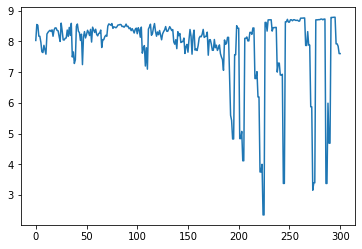

In [43]:
plt.plot(d_sample['l_E'][:,1])

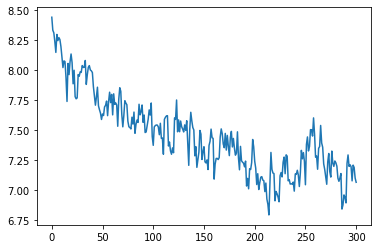

In [44]:
plt.plot(d_sample['l_E'].mean(dim=1))

In [13]:
d_sample_2 = d_sample

In [11]:
d_sample_1 = d_sample

In [14]:
d_sample_1.keys()

dict_keys(['l_x', 'l_E', 'x', 'img', 'img_E'])

In [15]:
d_sample_2.keys()

dict_keys(['l_x', 'l_E', 'x', 'img', 'img_E'])

In [21]:
d_sample_1['x'][0]

tensor([0.2386, 0.0762, 0.2573, 0.2156, 0.3587])

In [23]:
d_sample_2['x'][0]

tensor([0.3983, 0.8644, 0.6530, 0.7590, 1.0000])

In [19]:
xx = affine.transform(batch, x=d_sample_1['x'])

In [20]:
xx.shape

torch.Size([64, 3, 32, 32])

In [18]:
f = functools.partial(color.energy, img=batch.to(device))
D = 4
d_sample = sample_mh(x0=torch.rand(64,D).to(device), energy_fn=f, n_step=2000, stepsize=0.1, T=1, bound=(0, 1), block=None, mh=True)
l_E = d_sample['l_E']
mean_E = l_E.mean(dim=1)
std_E = l_E.std(dim=1)
argmin = l_E.argmin(dim=0)
min_x = d_sample['l_x'][argmin, range(len(argmin)), :]
min_E = l_E[argmin, range(len(argmin))]
cummin = torch.cummin(d_sample['l_E'], dim=0).values.mean(dim=1)

100%|██████████| 2000/2000 [01:51<00:00, 17.97it/s]


In [19]:
l_E.shape

torch.Size([2001, 64])

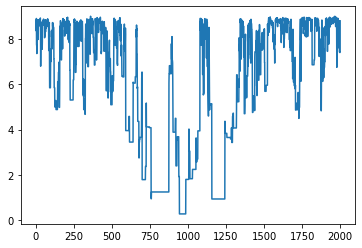

In [41]:
plt.plot(l_E[:,2])

In [23]:
d_sample['l_x'].shape

torch.Size([2001, 64, 5])

In [39]:
sorted_x = d_sample['l_x'][l_E[:,2].argsort(),1,:]

In [25]:
sorted_x.shape

torch.Size([2001, 5])

In [29]:
sorted_x

tensor([[1.0000, 0.8035, 0.6546, 0.0000, 0.2159],
        [1.0000, 0.8035, 0.6546, 0.0000, 0.2159],
        [1.0000, 0.8035, 0.6546, 0.0000, 0.2159],
        ...,
        [0.9454, 0.2285, 0.3705, 0.6334, 0.8549],
        [0.5111, 0.5303, 0.8443, 0.0025, 0.5349],
        [0.3933, 0.0857, 0.9519, 0.0000, 0.7382]])

In [42]:
xx = affine.transform(batch[[2]*len(sorted_x)], x=sorted_x)

In [31]:
xx.shape

torch.Size([2001, 3, 32, 32])

In [45]:
l_E[:,2].sort().values[0]

tensor(0.2779)

In [48]:
l_E[:,2].sort().values[96]

tensor(0.9371)

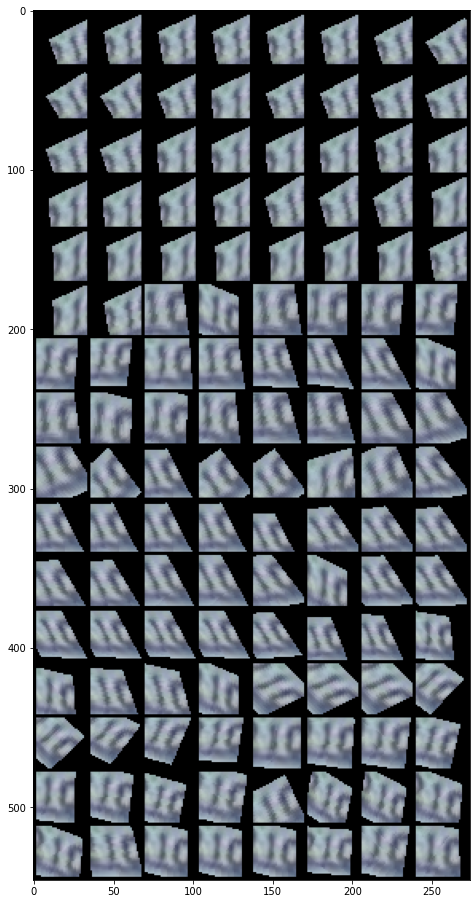

In [43]:
plt.figure(figsize=(16,16))
plt.imshow(make_grid(xx[:128],ncol=16).permute(1,2,0))

In [ ]:
sorted_x[